In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vtk_rw import read_vtk
import seaborn as sns

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### calculated from mesh

https://sites.google.com/site/dlampetest/python/calculating-normals-of-a-triangle-mesh-using-numpy

In [3]:
def calculate_normals(vertices, faces):
    
    triangles = vertices[faces]
    face_normals = np.cross( triangles[::,1 ] - triangles[::,0]  , triangles[::,2 ] - triangles[::,0] )
    #face_normals /= np.linalg.norm(face_normals, axis=1)[:,np.newaxis]
    face_normals /= 2 # weighting by surface area of the triangle, which is half the length of the normal
    
    vertex_normals = np.zeros(vertices.shape, dtype=vertices.dtype )
    vertex_normals[faces[:,0]] += face_normals
    vertex_normals[faces[:,1]] += face_normals
    vertex_normals[faces[:,2]] += face_normals
    vertex_normals /= np.linalg.norm(vertex_normals, axis=1)[:,np.newaxis]
    
    return vertex_normals

### from meshlab in object file

In [4]:
def read_obj(obj_file):
    obj_df=pd.read_csv(obj_file, header=None, engine='python', comment='#', sep=' ')
    obj_df=obj_df.dropna()

    vertex_df = obj_df.loc[np.where(obj_df[0] == 'v')[0]][[1,2,3]]
    vertex_array = np.asarray(vertex_df, dtype='float')

    if 'vn' in list(obj_df[0]):
        normals_df = obj_df.loc[np.where(obj_df[0] == 'vn')[0]][[1,2,3]]
        normals_array = np.asarray(normals_df, dtype='float')
    else:
        normals_array = np.empty(0)

    faces_df = obj_df.loc[np.where(obj_df[0] == 'f')[0]][[1,2,3]]
    faces_array = np.asarray(faces_df).copy()
    for i in range(faces_array.shape[0]):
        for j in range(faces_array.shape[1]):
            faces_array[i][j]=int(faces_array[i][j].split('//')[0])
    faces_array = np.asarray(faces_array, dtype='int64')-1
    
    return vertex_array, faces_array, normals_array

### comparing normals

In [5]:
def compare_normals(normals_a, normals_b):
    diff_rad = np.zeros((normals_a.shape[0],))
    for i in range(normals_a.shape[0]):
        diff_rad[i] = np.arccos(np.dot(normals_a[i], normals_b[i]))
    
    diff_deg = diff_rad  * (180/np.pi)
    return diff_rad, diff_deg

In [6]:
simple_v, simple_f, obj_simple_normals = read_obj('/scr/ilz3/myelinconnect/groupavg/indv_space/BP4T/lowres_rh_d_def.obj')

In [7]:
calc_simple_normals = calculate_normals(simple_v, simple_f)

In [8]:
complex_v, complex_f, obj_complex_normals = read_obj('/scr/ilz3/myelinconnect/struct/surf_rh/orig/mid_surface/BP4T_rh_mid.obj')

In [16]:
calc_complex_normals = calculate_normals(complex_v, complex_f)

In [17]:
mapping = np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/seeds/BP4T_rh_highres2lowres_seeds.npy')

In [18]:
obj_diff_rad, obj_diff_deg = compare_normals(obj_simple_normals, obj_complex_normals[mapping])

In [19]:
calc_diff_rad, calc_diff_deg = compare_normals(calc_simple_normals, calc_complex_normals[mapping])

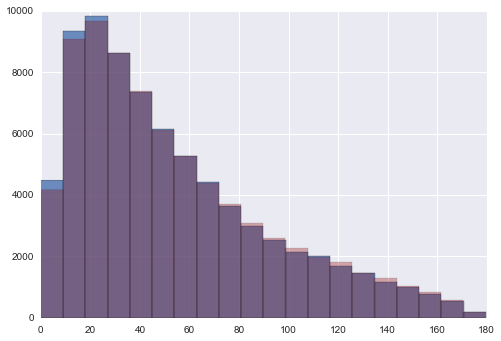

In [20]:
plt.hist(np.nan_to_num(obj_diff_deg), bins=20, alpha=0.8);
plt.hist(np.nan_to_num(calc_diff_deg), bins=20, alpha=0.3, color='darkred');

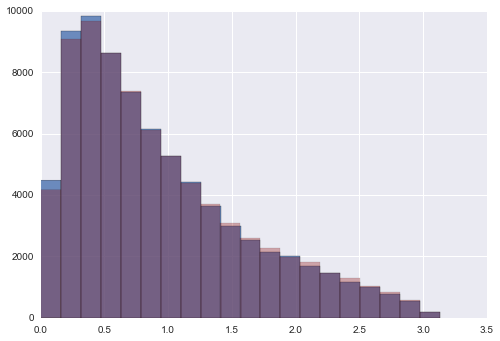

In [21]:
plt.hist(np.nan_to_num(obj_diff_rad), bins=20, alpha=0.8);
plt.hist(np.nan_to_num(calc_diff_rad), bins=20, alpha=0.3, color='darkred');

In [22]:
simple_calc_vs_obj_rad, simple_calc_vs_obj_deg = compare_normals(obj_simple_normals, calc_simple_normals)

In [23]:
complex_calc_vs_obj_rad, complex_calc_vs_obj_deg = compare_normals(obj_complex_normals, calc_complex_normals)

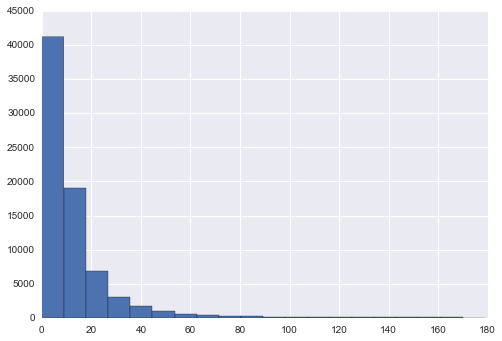

In [24]:
plt.hist(np.nan_to_num(simple_calc_vs_obj_deg), bins=20);

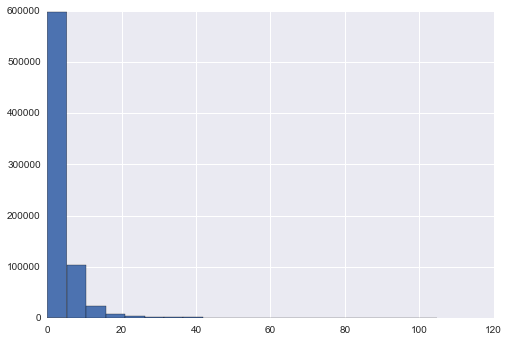

In [25]:
plt.hist(np.nan_to_num(complex_calc_vs_obj_deg), bins=20);

### updating voronoi function to take into account normals

In [ ]:
def find_voronoi_seeds(simple_vertices, complex_vertices):
    '''
    Finds those points on the complex mesh that correspoind best to the
    simple mesh while forcing a one-to-one mapping
    '''
    import numpy as np
    import scipy.spatial as spatial
    # make array for writing in final voronoi seed indices
    voronoi_seed_idx = np.zeros((simple_vertices.shape[0],), dtype='int64')-1
    missing = np.where(voronoi_seed_idx==-1)[0].shape[0]
    mapping_single = np.zeros_like(voronoi_seed_idx)

    neighbours = 0
    col = 0

    while missing != 0:

        neighbours += 100
        # find nearest neighbours
        inaccuracy, mapping  = spatial.KDTree(complex_vertices).query(simple_vertices, k=neighbours)
        # go through columns of nearest neighbours until unique mapping is
        # achieved, if not before end of neighbours, extend number of neighbours
        while col < neighbours:
            # find all missing voronoi seed indices
            missing_idx = np.where(voronoi_seed_idx==-1)[0]
            missing = missing_idx.shape[0]
            if missing == 0:
                break
            else:
                # for missing entries fill in next neighbour
                mapping_single[missing_idx]=np.copy(mapping[missing_idx,col])
                # find unique values in mapping_single
                unique, double_idx = np.unique(mapping_single, return_inverse = True)
                # empty voronoi seed index
                voronoi_seed_idx = np.zeros((simple_vertices.shape[0],), dtype='int64')-1
                # fill voronoi seed idx with unique values
                for u in range(unique.shape[0]):
                    # find the indices of this value in mapping
                    entries = np.where(double_idx==u)[0]
                    # set the first entry to the value
                    voronoi_seed_idx[entries[0]] = unique[u]
                # go to next column
                col += 1 
                
    return voronoi_seed_idx, inaccuracy

In [9]:
simple_vertices=simple_v
simple_faces=simple_f
complex_vertices=complex_v
complex_faces=complex_f

In [10]:
cutoff_euclid=2.0
cutoff_rad = np.pi/2

In [11]:
def find_voronoi_seeds(simple_vertices, simple_faces, complex_vertices, complex_faces, cutoff_euclid=2.0, cutoff_rad=(np.pi/2)):
    '''
    Finds those points on the complex mesh that correspond best to the
    simple mesh (taking into accound euclidian distance and direction of normals)
    while forcing a one-to-one mapping
    '''
    from bintrees import FastAVLTree
    import scipy.spatial as spatial

    neighbours = 100

    # calculate normals for simple and complex vertices
    simple_normals = calculate_normals(simple_vertices, simple_faces)
    complex_normals = calculate_normals(complex_vertices, complex_faces)

    # find nearest neighbours of simple vertices on complex mesh using kdtree
    inaccuracy, mapping  = spatial.KDTree(complex_vertices).query(simple_vertices, k=neighbours)

    # create tidy long-format lists
    simple_idxs = np.asarray([neighbours*[simple_idx] for simple_idx in range(simple_vertices.shape[0])]).flatten()
    candidate_idxs = mapping.flatten()
    diff_euclid = inaccuracy.flatten()

    # for each vertex pair calculate the angle between their normals
    diff_normals, _ = compare_normals(simple_normals[simple_idxs], complex_normals[candidate_idxs])

    # remove those pairs that have an angle > 90° and/or distance > 2 mm
    mask = np.unique(np.concatenate((np.where(diff_euclid>cutoff_euclid)[0], np.where(diff_normals>cutoff_rad)[0])))
    diff_normals = np.delete(diff_normals, mask)
    diff_euclid = np.delete(diff_euclid, mask)
    simple_idxs = np.delete(simple_idxs, mask)
    candidate_idxs = np.delete(candidate_idxs, mask)

    # calculate scores for each vertex pair
    scores = (diff_normals-np.mean(diff_normals)) + (diff_euclid-np.mean(diff_euclid))

    # make a binary search tree from the scores and vertex pairs, 
    # organisation is key: score, values: tuple(simple_vertex, candiate_complex_vertex)
    tree = FastAVLTree(zip(scores, zip(simple_idxs, candidate_idxs)))

    voronoi_seed_idx = np.zeros((simple_vertices.shape[0],), dtype='int64')-1
    missing = np.where(voronoi_seed_idx==-1)[0].shape[0]

    while missing > 0:

        min_item =  tree.pop_min()
        simple_idx = min_item[1][0]
        candidate_idx = min_item[1][1]

        if (voronoi_seed_idx[simple_idx] == -1):
            if candidate_idx not in voronoi_seed_idx:
                voronoi_seed_idx[simple_idx] = candidate_idx
            else:
                pass
        else:
            pass

        missing = np.where(voronoi_seed_idx==-1)[0].shape[0]

        if tree.count > 0:
            print "tree is empty"
            break

    return voronoi_seed_idx, inaccuracy

(array([   1410.,    8095.,   20639.,   39058.,   64011.,   93197.,
         127030.,  165372.,  207334.,  251534.,  300810.,  350005.,
         403252.,  455405.,  504093.,  547536.,  572877.,  527549.,
         391912.,  275404.]),
 array([-1.36339085, -1.26389091, -1.16439096, -1.06489102, -0.96539108,
        -0.86589113, -0.76639119, -0.66689124, -0.5673913 , -0.46789136,
        -0.36839141, -0.26889147, -0.16939152, -0.06989158,  0.02960836,
         0.12910831,  0.22860825,  0.3281082 ,  0.42760814,  0.52710808,
         0.62660803]),
 <a list of 20 Patch objects>)

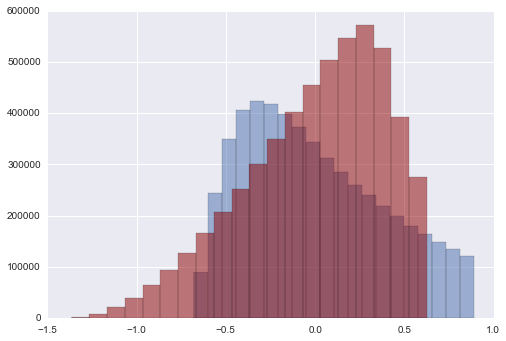

In [33]:
plt.hist(diff_normals-np.mean(diff_normals), alpha=0.5, bins=20)
plt.hist((diff_euclid-np.mean(diff_euclid)), alpha=0.5, bins=20, color='darkred')

In [34]:
scores = (diff_normals-np.mean(diff_normals)) + (diff_euclid-np.mean(diff_euclid))

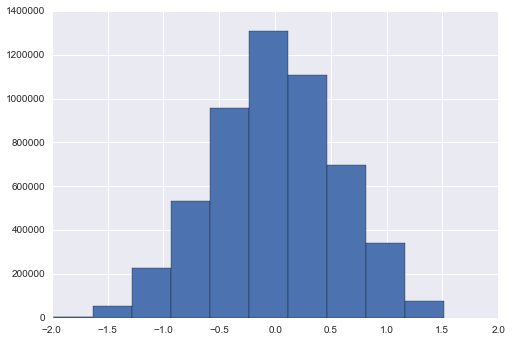

In [35]:
plt.hist(scores);

In [38]:
tree = FastAVLTree(zip(scores, zip(simple_idxs, candidate_idxs)))

In [39]:
voronoi_seed_idx = np.zeros((simple_vertices.shape[0],), dtype='int64')-1
missing = np.where(voronoi_seed_idx==-1)[0].shape[0]

In [ ]:
while missing > 0:

In [44]:
min_item =  tree.pop_min()
simple_idx = min_item[1][0]
candidate_idx = min_item[1][1]

In [45]:
simple_idx

44945

In [46]:
candidate_idx

404362

In [49]:
test_normals_simple =calculate_normals(simple_v, simple_f)
test_normals_complex =calculate_normals(complex_v, complex_f)

In [65]:
test_normal, _ = compare_normals(test_normals_simple[simple_idx][np.newaxis, :], test_normals_complex[candidate_idx][np.newaxis, :])

In [66]:
test_euclid = inaccuracy[simple_idx][np.where(mapping[simple_idx]==candidate_idx)]

In [67]:
test_normal - np.mean(diff_normals) + test_euclid - np.mean(diff_euclid)

array([-1.9845857])

In [68]:
min_item[0]

-1.9845856972274425

In [71]:
if (voronoi_seed_idx[simple_idx] == -1):
    if candidate_idx not in voronoi_seed_idx:
        voronoi_seed_idx[simple_idx] = candidate_idx
    else:
        pass
else:
    pass

missing = np.where(voronoi_seed_idx==-1)[0].shape[0]

if tree.count > 0:
    print "tree is empty"
    break

In [73]:
voronoi_seed_idx[simple_idx]

404362

In [74]:
candidate_idx in voronoi_seed_idx

True

In [75]:
missing

75588